# **Special Data Processing : Additional Task** 

### **Image Classification : Cat detection**

**Problem Statement**: We are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.


Firstly, let's load our data !

In [ ]:
# %pip install h5py

Documentation of h5py [here](https://docs.h5py.org/en/stable/quick.html#quick)

In [63]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
import random

In [33]:
def load_dataset():
    # Load the .h5 file and store it as a dictionnary
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [34]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

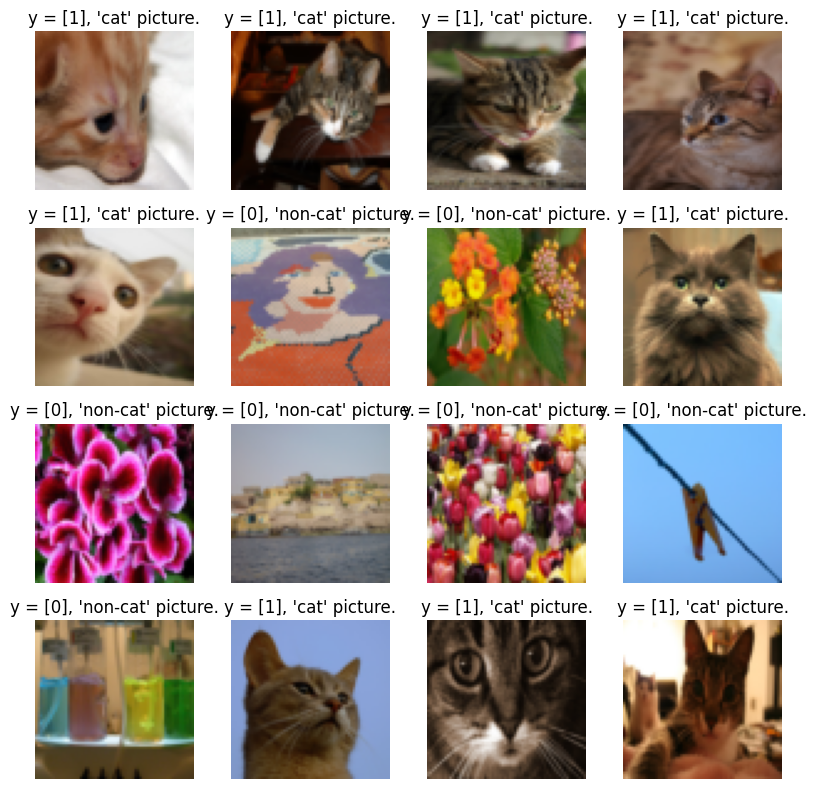

In [65]:
# Créez une figure avec une grille de sous-graphiques 4x4
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Indices des images que vous souhaitez afficher
indices = random.sample(range(len(train_set_x_orig)), 16)

# Parcourez les indices et affichez les images dans les sous-graphiques
for i, index in enumerate(indices):
    row = i // 4  # Ligne actuelle (0 à 3)
    col = i % 4   # Colonne actuelle (0 à 3)
    
    axs[row, col].imshow(train_set_x_orig[index])
    axs[row, col].set_title("y = " + str(train_set_y[:, index]) + ", '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")
    axs[row, col].axis('off')  # Désactivez les axes pour une meilleure présentation

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez la figure
plt.show()


In [36]:
# Nb of training examples
m_train = train_set_x_orig.shape[0]

# Nb of test examples
m_test = test_set_x_orig.shape[0]

# Height/Width of each example
num_px = train_set_x_orig.shape[1] 

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


We have now to reshape our training and test dataset from (num_px, num_px, 3) to (nump_px * num_px * 3, 1). We will obtain flattened image ready to use by the neuron network.

In [37]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T

test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


>`train_set_x_orig.shape[0], -1` is used as an argument for `reshape`. The use of `-1` in the second dimension means that NumPy should automatically calculate the necessary size for this dimension while ensuring that the total number of elements remains the same. This effectively flattens each image into a single row while keeping the total number of pixels unchanged.

>`.T` transposes the resulting output. In other words, the flattened images that were previously arranged in rows are now arranged in columns.

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize our dataset, meaning that we substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

During the training of your model, we're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then we backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode.

Let's standardize our dataset.

In [38]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='red'>

**What we need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

**Building the model**

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

In [43]:
def sigmoid(z): 
    return 1 / (1 + np.exp(-z))

def intialize_weigth(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim, 1))
    b = 0.

    return w, b

Forward Propagation:
- We get X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas we will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [52]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the forward propagation

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    m = X.shape[1]

    a = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m * np.sum(Y * np.log(a) + (1 - Y) * np.log(1 - a))

    dw = 1/m * np.dot(X, (a - Y).T)
    db = 1/m * np.sum(a - Y)

    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def gradient_descent(w, b, X, Y, num_iterations=100, learning_rate=0.009):
    """ 
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        dw = grads['dw']
        db = grads['db']

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100:
            costs.append(cost)

    params = {"w": w,
            "b": b}
    
    return params, costs

def predict(w, b, X, treshsold=0.5):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    z = np.dot(w.T, X) + b
    A = sigmoid(z)

    for i in range(m):
        if A[0,i] > treshsold:
            Y_prediction[0,i] = 1
        else: Y_prediction[0,i] = 0
    
    return Y_prediction

<font color='red'>
    
**What to remember:**

- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - Computing the cost and its gradient 
    - Updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

Time to build the model !

In [56]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=10000, learning_rate=0.5):

    # Initialize parameters
    w, b = intialize_weigth(X_train.shape[0])
    
    # Train the model : apply gradient descent (forward and backward propagation)
    params, costs = gradient_descent(w, b, X_train, Y_train, num_iterations=num_iterations, learning_rate=learning_rate)

    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print the accuracy of the model
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    # Plot learning curve (with costs)
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return d


Let it work...

train accuracy: 100.0 %
test accuracy: 70.0 %


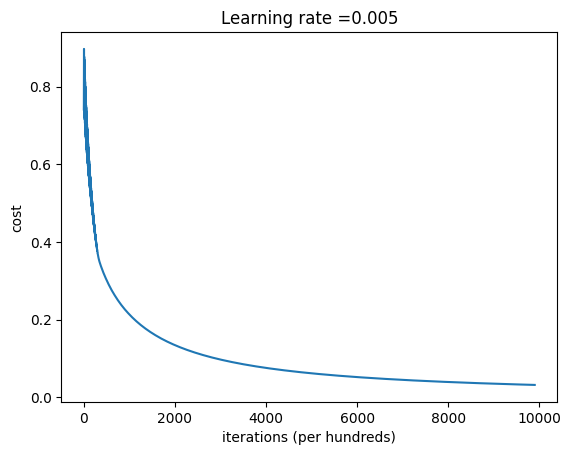

In [59]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=10000, learning_rate=0.005)